In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import lightgbm as lgb

from causalml.dataset import make_uplift_classification
from causalml.inference.meta import BaseTClassifier
from causalml.optimize import get_treatment_costs, get_actual_value, CounterfactualValueEstimator

from uplift.meta_learner import XLearner
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from causalml.metrics import auuc_score, get_cumgain, plot_gain

sns.set_style('whitegrid')

%matplotlib inline


/home/sean/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
df, X_names = make_uplift_classification(
    n_samples=5000,
    treatment_name=["control", "treatment1", "treatment2"],
    positive_class_proportion=0.1,
)

In [3]:
df['expected_value'] = np.abs(df['x6_irrelevant']) * 20 + np.random.normal(0, 5)

In [4]:
# Put costs into dicts
conversion_cost_dict = {"control": 0, "treatment1": 2.5, "treatment2": 10}
impression_cost_dict = {"control": 0, "treatment1": 0, "treatment2": 0.02}

# Use a helper function to put treatment costs to array
cc_array, ic_array, conditions = get_treatment_costs(
    treatment=df["treatment_group_key"],
    control_name="control",
    cc_dict=conversion_cost_dict,
    ic_dict=impression_cost_dict,
)

# Put the conversion value into an array
conversion_value_array = df['expected_value'].to_numpy()

In [5]:
# Use a helper function to obtain the value of actual treatment
actual_value = get_actual_value(
    treatment=df["treatment_group_key"],
    observed_outcome=df["conversion"],
    conversion_value=conversion_value_array,
    conditions=conditions,
    conversion_cost=cc_array,
    impression_cost=ic_array,
)

In [6]:
df_train, df_test = train_test_split(df)
train_idx = df_train.index
test_idx = df_test.index

### Random Policy

In [7]:
test_actual_value = actual_value.loc[test_idx]
random_treatments = pd.Series(
    np.random.choice(conditions, test_idx.shape[0]), index=test_idx
)
test_treatments = df.loc[test_idx, "treatment_group_key"]
random_allocation_value = test_actual_value[test_treatments == random_treatments]


### Best Treatment Policy

In [8]:
best_ate = df_train.groupby("treatment_group_key")["conversion"].mean().idxmax()

actual_is_best_ate = df_test["treatment_group_key"] == best_ate

best_ate_value = actual_value.loc[test_idx][actual_is_best_ate]

### X Learner

In [9]:
xm = XLearner()
encoder = {"control": 0, "treatment1": 1, "treatment2": 2}
X = df.loc[train_idx, X_names].to_numpy()
y = df.loc[train_idx, "conversion"].to_numpy()
T = np.array([encoder[x] for x in df.loc[train_idx, "treatment_group_key"]])

xm.fit(X, y, T)

In [10]:
X_test = df.loc[test_idx, X_names].to_numpy()
xm_pred = xm.predict(X_test).drop(0, axis=1)
xm_best = xm_pred.idxmax(axis=1)
xm_best = [conditions[idx] for idx in xm_best]

actual_is_xm_best = df_test["treatment_group_key"] == xm_best
xm_value = actual_value.loc[test_idx][actual_is_xm_best]

### CVE

In [11]:
proba_model = lgb.LGBMClassifier()

W_dummies = pd.get_dummies(df["treatment_group_key"])
XW = np.c_[df[X_names], W_dummies]

proba_model.fit(XW[train_idx], df_train["conversion"])
y_proba = proba_model.predict_proba(XW[test_idx])[:, 1]

In [12]:
expected_value_model = lgb.LGBMRegressor()
expected_value_model.fit(XW[train_idx], df_train['expected_value'])
pred_conv_value = expected_value_model.predict(XW[test_idx])

In [13]:
# Run the counterfactual calculation with TwoModel prediction
cve = CounterfactualValueEstimator(
    treatment=df_test["treatment_group_key"],
    control_name="control",
    treatment_names=conditions[1:],
    y_proba=y_proba,
    cate=xm_pred,
    value=pred_conv_value,
    conversion_cost=cc_array[test_idx],
    impression_cost=ic_array[test_idx],
)

cve_best_idx = cve.predict_best()
cve_best = [conditions[idx] for idx in cve_best_idx]
actual_is_cve_best = df.loc[test_idx, "treatment_group_key"] == cve_best
cve_value = actual_value.loc[test_idx][actual_is_cve_best]

### Net Value Optimized X Learner


In [14]:
%%capture

encoder = {"control": 0, "treatment1": 1, "treatment2": 2}

ic_lookup = {0: 0, 1: 0.1, 2: 0.1}
cc_lookup = {0: 0, 1: 5, 2: 10}

nvex = XLearner(ic_lookup=ic_lookup, cc_lookup=cc_lookup)

X = df.loc[train_idx, X_names].to_numpy()
y = df.loc[train_idx, "conversion"].to_numpy()
T = np.array([encoder[x] for x in df.loc[train_idx, "treatment_group_key"]])
value = df.loc[train_idx, "expected_value"].to_numpy()

nvex.fit(X, y, T, value)


In [15]:
X_test = df.loc[test_idx, X_names].to_numpy()
nvex_preds = nvex.get_best_action(X_test)

nvex_best = [conditions[idx] for idx in nvex_preds]
actual_is_nvex_best = df.loc[test_idx, "treatment_group_key"] == nvex_best
nvex_value = actual_value.loc[test_idx][actual_is_nvex_best]

In [16]:
test_value = actual_value.loc[test_idx]
best_value = test_value[test_value >= 0]


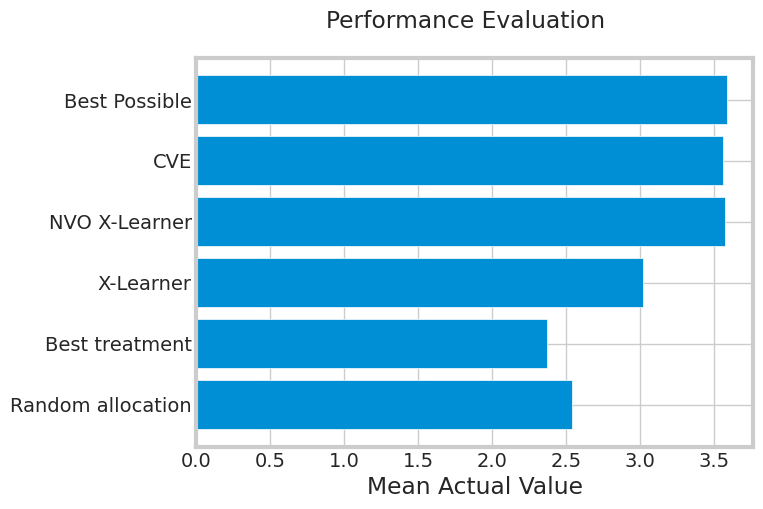

In [23]:
labels = [
    "Random allocation",
    "Best treatment",
    "X-Learner",
    "NVO X-Learner",
    "CVE",
    "Best Possible",
]

values = [
    random_allocation_value,
    best_ate_value,
    xm_value,
    nvex_value,
    cve_value,
    best_value,
]

bar_plot_values = [x.mean() for x in values]

plt.suptitle('Performance Evaluation')
plt.barh(labels, bar_plot_values)
plt.xlabel("Mean Actual Value")
plt.show()